### Informasi Dataset
Data yang disediakan terkait dengan kampanye pemasaran langsung dari lembaga perbankan Portugis. Kampanye pemasaran didasarkan pada panggilan telepon. Seringkali, lebih dari satu kontak ke klien yang sama diperlukan, untuk mengakses apakah produk (deposit berjangka bank) akan ('ya') atau ('tidak') tidak berlangganan. Deposit adalah istilah dalam keuangan yang dapat diartikan sebagai transfer dana ke pihak lain seperti bank untuk diamankan. Selain itu, deposit juga bisa mengacu pada saat sebagian dana digunakan sebagai jaminan sebelum bisa memperoleh sebuah barang.

Ada empat dataset:

- bank-additional-full.csv dengan semua contoh (41188) dan 20 input, diurutkan berdasarkan tanggal (dari Mei 2008 hingga November 2010), sangat dekat dengan data yang dianalisis dalam [Moro et al., 2014]
- bank-additional.csv dengan 10% contoh (4119), dipilih secara acak dari 1), dan 20 masukan.
- bank-full.csv dengan semua contoh dan 17 input, diurutkan berdasarkan tanggal (versi lama dari kumpulan data ini dengan input yang lebih sedikit).
- bank.csv dengan 10% contoh dan 17 masukan, dipilih secara acak dari 3 (versi lama kumpulan data ini dengan masukan lebih sedikit).

Kumpulan data terkecil disediakan untuk menguji algoritme pembelajaran mesin yang menuntut komputas (mis., SVM).

Dataset ini berisi
#### Input var

- bank client data: </br>
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default?(categorical: 'no', 'yes', 'unknown')
6 - housing: has housing loan?(categorical: 'no', 'yes', 'unknown')
7 - loan: has personal loan?(categorical: 'no', 'yes', 'unknown')
- related with the last contact of the current campaign:</br>
8 - contact: contact communication type (categorical: 'cellular', 'telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon', 'tue', 'wed', 'thu', 'fri')
11 - duration: last contact duration, in seconds (numeric).Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no').Yet, the duration is not known before a call is performed.Also, after the end of the call y is obviously known.Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

- other attributes:</br>
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure', 'nonexistent', 'success')
- social and economic context attributes </br>
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

### Permasalahan
Menentukan strategi terbaik untuk ditingkatkan pada kampanye pemasaran berikutnya. Bagaimana lembaga keuangan memiliki efektivitas yang lebih besar untuk kampanye pemasaran di masa depan? Untuk menjawab ini, kita harus menganalisis kampanye pemasaran terakhir yang dilakukan bank dan mengidentifikasi pola yang akan membantu kita menemukan kesimpulan untuk mengembangkan strategi masa depan.

### Install Pustaka

In [1]:
# Data processing
import pandas as pd
import numpy as np
from collections import Counter

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
cols= ['#00876c','#85b96f','#f7e382','#f19452','#d43d51']

# Machine learning process
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


# features analysis libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.decomposition import PCA

%matplotlib inline

### Loading Data

In [2]:
# menggunakan dua dataset yang full.
bank_df = pd.read_excel('dataset/bank-additional-full.xlsx')

In [3]:
# Menampilkan 5 data teratas
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no


In [4]:
# Menampilkan info dari dataset
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Analisis: 
* Categorical Variables:job,marital, default, education,housing,loan,contact,poutcome,mounth,y (deposit),day
* Numerical Variables: age, campaign,duration, pdays,balance,previous

y disini adalah deposit sebagai dependent variaabel

### Data Cleaning

#### Categorical Value

In [5]:
# Categorical Value
def bar_plot(variable):
    var =bank_df[variable]
    varValue = var.value_counts()
    plt.figure(figsize=(15,3))
    plt.bar(varValue.index, varValue,color=cols)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    
    plt.show()
    print("{}: \n {}".format(variable,varValue))

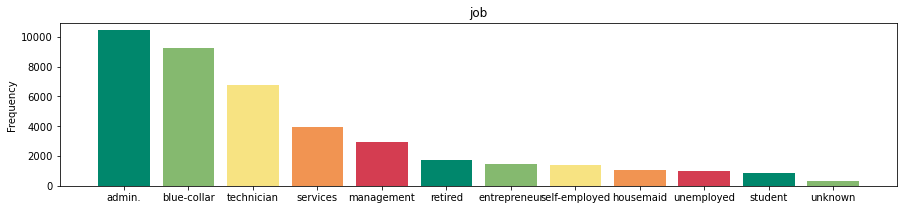

job: 
 admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64


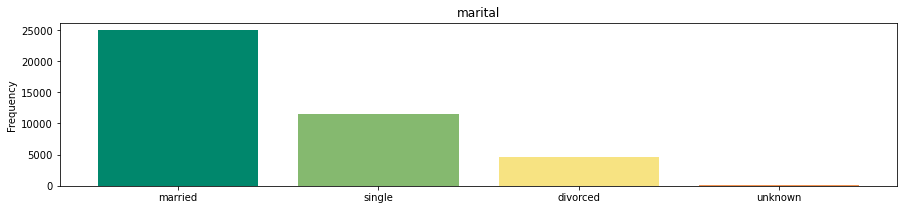

marital: 
 married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


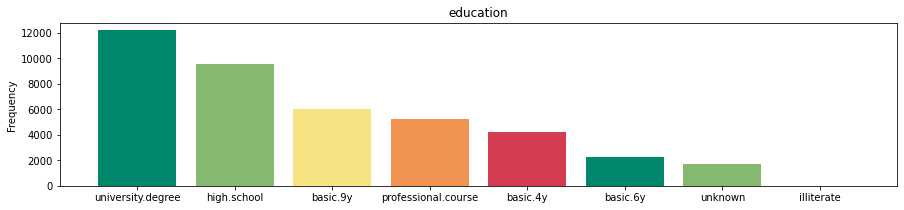

education: 
 university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64


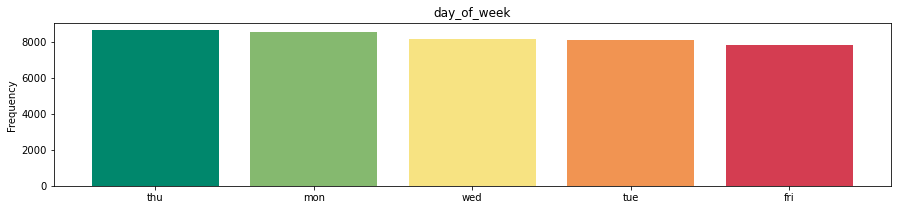

day_of_week: 
 thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64


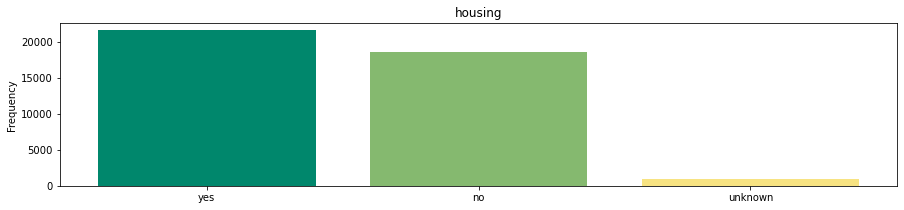

housing: 
 yes        21576
no         18622
unknown      990
Name: housing, dtype: int64


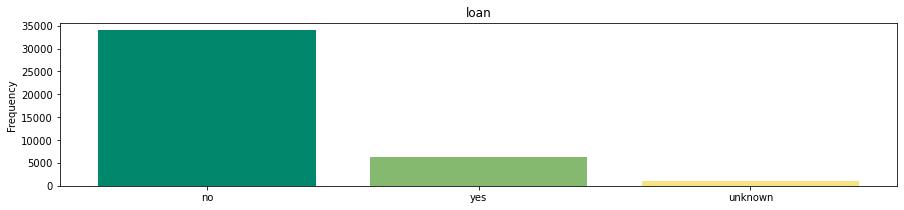

loan: 
 no         33950
yes         6248
unknown      990
Name: loan, dtype: int64


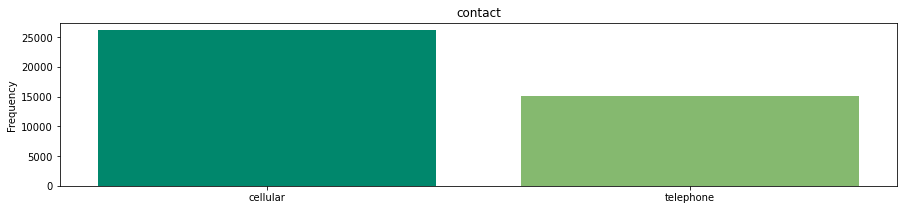

contact: 
 cellular     26144
telephone    15044
Name: contact, dtype: int64


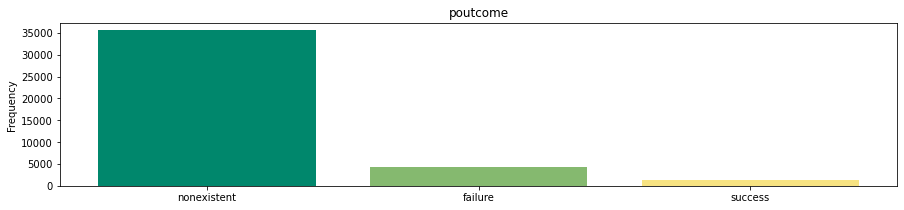

poutcome: 
 nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64


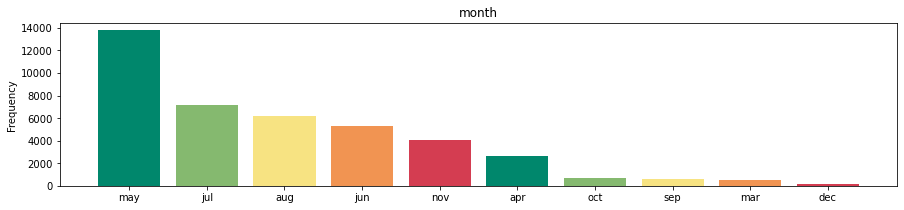

month: 
 may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64


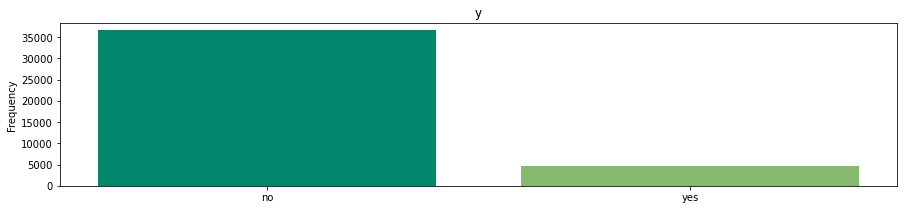

y: 
 no     36548
yes     4640
Name: y, dtype: int64


In [6]:
# menampilkan value beserta jumlah value dari setiap category 
categoryc = ["job","marital","education", "day_of_week","housing", "loan","contact","poutcome","month","y"]
for c in categoryc:
    bar_plot(c)

Analisis
- Beberapa kategori masih terdapat missing value "unknown"

#### Numerical Value

In [7]:
def plot_hist(variable):
    plt.figure(figsize=(9,6))
    plt.hist(bank_df[variable], bins=40,color='#cd1076')
    plt.xlabel(variable)
    plt.ylabel("frequency")
    plt.title("{} distrubition with hist".format(variable))
    plt.show()

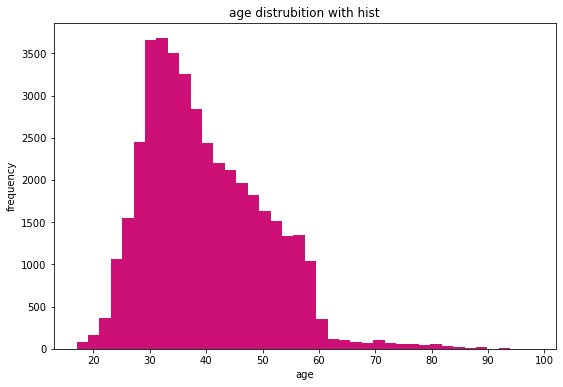

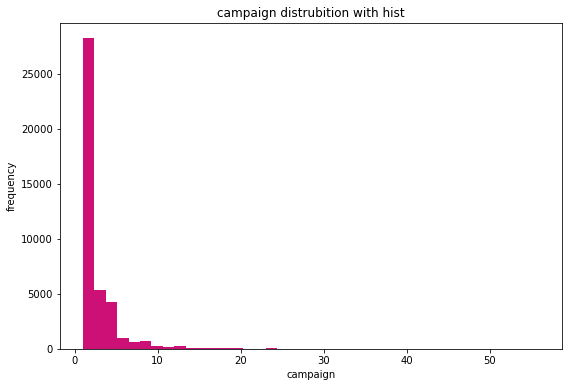

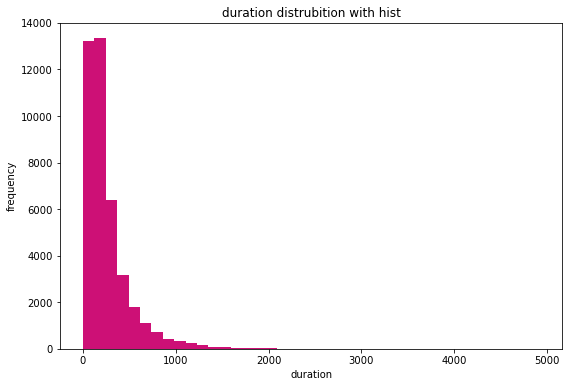

In [8]:
numericVar = ["age","campaign","duration"]
for n in numericVar:
    plot_hist(n)

In [9]:
print("Jumlah nan missing values atribut numerikal = ",bank_df[numericVar].isnull().sum().sum())

Jumlah nan missing values atribut numerikal =  0


Analisis
- Terlihat beberapa kategori data masih ada yang jauh dari kumpulan (outlier) 
- Setelah dicek dengan menghitung nan, tidak terdapat missing value

#### Outliers Detection (Numerical Value)

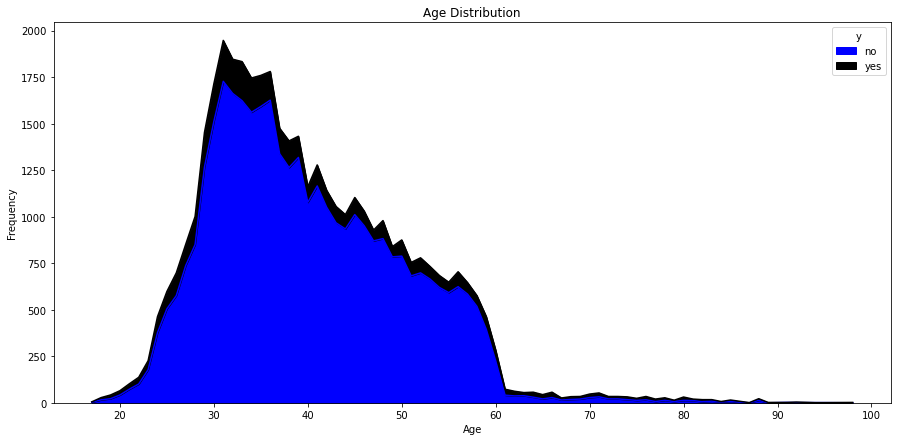

In [10]:
# cek banyak deposit berdasarkan age
pd.crosstab(bank_df.age,bank_df.y).plot(kind="area",figsize=(15,7),color=['#0000ff','#000000' ])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Analisis
- Jumlah orang yang berusia 25 hingga 40 tahun dengan rekening deposito berjangka, tinggi.

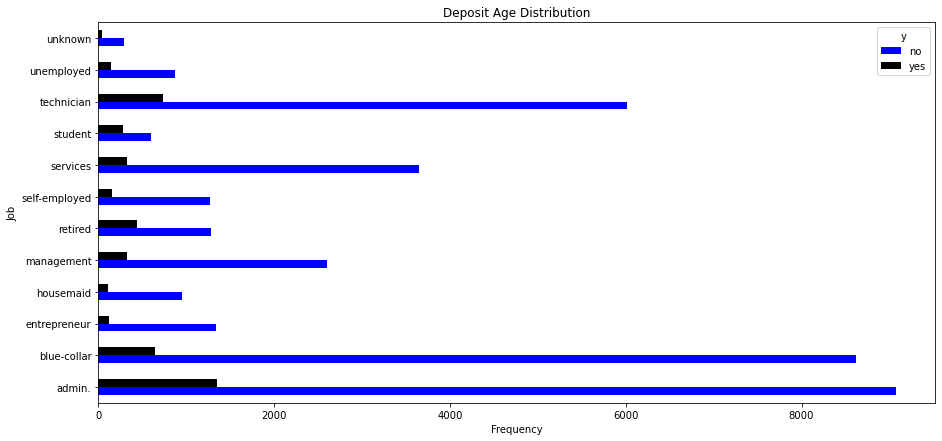

In [11]:
pd.crosstab(bank_df.job,bank_df.y).plot(kind="barh",figsize=(15,7),color=['#0000ff','#000000'])
plt.title('Deposit Job Distribution')
plt.xlabel('Frequency')
plt.ylabel('Job')
plt.show()

Analisis
- Student memiliki perbandingan (y/n) deposit yang lebih seimbang dibandingkan yang lainnya.
- Admin paling banyak tidak berlangganan deposit. Paling banyak berlangganan deposit

In [12]:
def detect_outliers(data,features):
    outlier_indices = []
    for c in features:
        # 1st quartile
        Q1 = np.percentile(data[c],25)
        # 3rd quartile
        Q3 = np.percentile(data[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = data[(data[c] < Q1 - outlier_step) | (data[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [13]:
outlier_df=bank_df.loc[detect_outliers(bank_df,['age','duration','campaign','previous'])]
outlier_df


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
35973,78,retired,married,high.school,no,yes,no,cellular,may,mon,...,2,3,2,failure,-1.8,92893.0,-46.2,1264.000,5099.1,no
37193,74,retired,married,high.school,no,yes,no,cellular,aug,thu,...,1,999,1,failure,-2.9,92201.0,-31.4,0.883,5076.2,yes
37861,72,unknown,married,unknown,no,yes,yes,cellular,aug,fri,...,8,999,1,failure,-2.9,92201.0,-31.4,0.825,5076.2,yes
38022,91,retired,married,university.degree,no,yes,yes,cellular,sep,wed,...,1,999,2,failure,-3.4,92379.0,-29.8,0.781,5017.5,no
38074,70,admin.,married,basic.4y,no,no,no,cellular,sep,tue,...,1,999,2,failure,-3.4,92379.0,-29.8,0.770,5017.5,yes
38179,83,retired,married,professional.course,no,yes,no,cellular,oct,fri,...,2,4,1,success,-3.4,92431.0,-26.9,0.752,5017.5,yes
38247,70,retired,married,university.degree,no,yes,no,cellular,oct,mon,...,2,999,1,failure,-3.4,92431.0,-26.9,0.743,5017.5,no
38676,73,retired,married,university.degree,no,no,yes,cellular,nov,thu,...,7,999,0,nonexistent,-3.4,92649.0,-30.1,0.716,5017.5,yes
38846,75,housemaid,divorced,basic.4y,no,no,no,telephone,nov,mon,...,8,3,1,success,-3.4,92649.0,-30.1,0.714,5017.5,no
38984,80,retired,divorced,basic.4y,no,no,yes,cellular,dec,fri,...,5,999,1,failure,-3.0,92713.0,-33.0,0.718,5023.5,no


In [14]:
bank_df = bank_df.drop(outlier_df.index, axis=0)

Outlier sudah diremove

#### Menangani Missing Value

Dari diagram sebelumnya, ditemukan value "unknown" pada beberapa kolom dengan tipa kategorikal dan tidak terdeteksi oleh funggsi isnull, untuk itu diganti dengan nan supaya terdeteksi

In [15]:
bank_df[bank_df[categoryc] == "unknown" ] = np.nan

In [16]:
bank_df.isnull().sum()

age                  0
job                329
marital             80
education         1727
default              0
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

Missing value sudah terdeteksi dengn fungsi isnull. Penanganan akan dilakukan dengan mengganti nilai missing value dengan modus karena kolom bertipe kategorical.


In [17]:
imputer_categorical = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [18]:
imputer_categorical.fit(bank_df[categoryc])
bank_df[categoryc] = imputer_categorical.transform(bank_df[categoryc])

In [19]:
print("Jumlah nan missing values atribut kategori = ",bank_df[categoryc].isnull().sum().sum())

Jumlah nan missing values atribut kategori =  0


Sudah berhasil mengganti nan ke modus untuk kategorical value

### Exploratory Data Analysis 

In [20]:
# Ganti penaamaan y ke deposit supaya lebih mudah dimengerti
bank_df.rename(columns={'y' : 'deposit' },inplace=True)

No handles with labels found to put in legend.


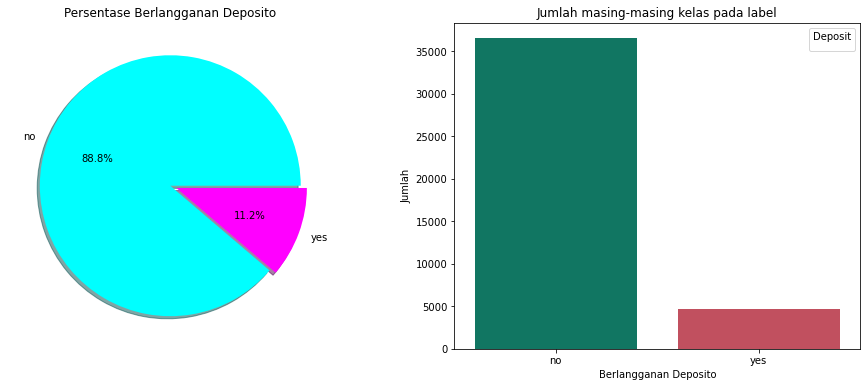

In [21]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

# persentase "berlangganan deposito"
bank_df['deposit'].value_counts().plot(
    kind='pie',
    autopct='%.1f%%',
    explode=[0,0.05], 
    cmap='cool',
    shadow=True,
    ax=ax[0]
)

ax[0].set_title('Persentase Berlangganan Deposito')
ax[0].set_ylabel('')

# Barchart besaran setiap nilai pada kelas target
sns.barplot(x=bank_df.deposit.value_counts().index, y=bank_df.deposit.value_counts(), palette=['#00876c','#d43d51'])
ax[1].set_title('Jumlah masing-masing kelas pada label')
ax[1].set_ylabel('Jumlah')
ax[1].set_xlabel('Berlangganan Deposito')
ax[1].legend(title='Deposit')

Analisis:

Ada ketidakseimbangan value yes dan no.  Hal ini mungkin akan berpengaruh kepada hasil recall klasifikasi yang rendah. Metode samling undersampling bisa jadi opsi ketika performa model klasifikasi tidak cukup bagus untuk mengenali kelas 'yes'.

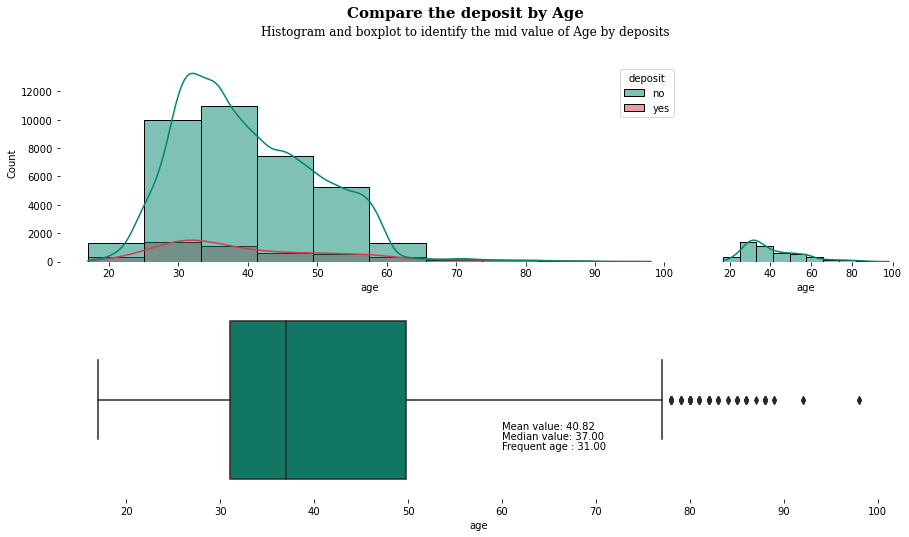

In [22]:
# deposit/deposito dimulai dari kolom "y"

fig=plt.figure(figsize=(15,8), facecolor=(0.2,0.0,0.0,0.0), edgecolor='black')
plt.suptitle("Compare the deposit by Age", family='Serif', size=15,weight='bold')

plt.figtext(0.5,0.93,"Histogram and boxplot to identify the mid value of Age by deposits", family='Serif', size=12, ha='center')
gs = GridSpec(nrows=2, ncols=4, figure=fig)
ax1=plt.subplot(gs[0,:3])

sns.histplot(data=bank_df, x='age', bins=10, ax=ax1, kde=True, hue='deposit', multiple='layer', element='bars', palette=['#00876c','#d43d51']);
ax2=plt.subplot(gs[0,3:4], sharey=ax1)
sns.histplot(data=bank_df[bank_df['deposit']=='yes'], x='age', bins=10, ax=ax2, kde=True, color=['#00876c']);
ax2.yaxis.set_visible(False)

ax4=plt.subplot(gs[1,:4])
sns.boxplot(data=bank_df[bank_df['deposit']=='yes'], x='age', ax=ax4, palette=['#00876c']);
ax4.yaxis.set_visible(False)
ax4.text(60,0.15,"Mean value: {:.2f}".format(bank_df[bank_df['deposit']=='yes']['age'].mean()))
ax4.text(60,0.20,"Median value: {:.2f}".format(bank_df[bank_df['deposit']=='yes']['age'].median()))
ax4.text(60,0.25,"Frequent age : {:.2f}".format(bank_df[bank_df['deposit']=='yes']['age'].mode().max()))
for i in ['left','right','bottom','top']:
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax4.spines[i].set_visible(False)

Analisis:
Hasil menarik dari grafik di atas. deposito dimulai pada usia 20+ dan puncak antara 30, 50. sering usia deposito adalah 32. Selain itu usia non deposito adalah antara 30-50 tahun dengan rata-rata sekitar 35-40 tahun

Text(0.05, -0.05, "Observation:\n Obivous that the single's y is less compared to married & divorced.\n Married average age starts from 35+ to 60.\n divorced ages is between 40 to 60 & singel ages is between 28 to 35.\n Reason could be that the single might get married after 35 years approximately")

findfont: Font family ['San'] not found. Falling back to DejaVu Sans.


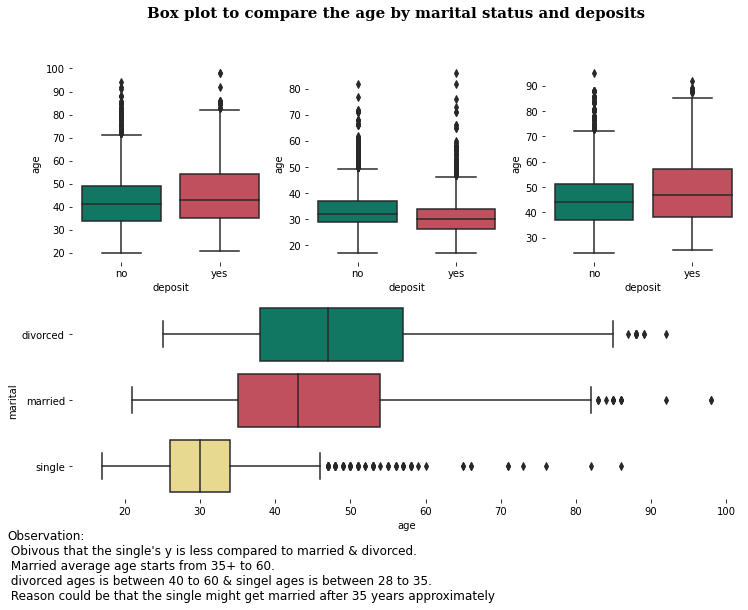

In [23]:
fig = plt.figure(figsize=(12,8))
gs = GridSpec(ncols=3, nrows=2, figure=fig)
plt.suptitle("Box plot to compare the age by marital status and deposits", family='Serif', weight='bold', size=15)
for i,c in enumerate(bank_df['marital'].unique()):
    ax=plt.subplot(gs[0,i])
    ax=sns.boxplot(y=bank_df[bank_df['marital']==c]['age'], x=bank_df['deposit'],palette=['#00876c','#d43d51']);
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

ax=plt.subplot(gs[1,:])
ax=sns.boxplot(data=bank_df[bank_df['deposit']=='yes'],y='marital',x='age', palette=['#00876c','#d43d51','#f7e382'])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)



Analisis
- Single lebih sedikit untuk berlangganan deposit dibandingkan married dan divorce
- Rata-rata umur married dimulai dari 35+ to 60. 
- Umur divorced diantara 40 to 60 & umur singel diantara 28 to 35.
- Penyebabnya mungkin single akan menikah setelah 35 (rata-ratanya) 

Text(0.05, -0.05, 'Observation: People who has loan, have not deposited')

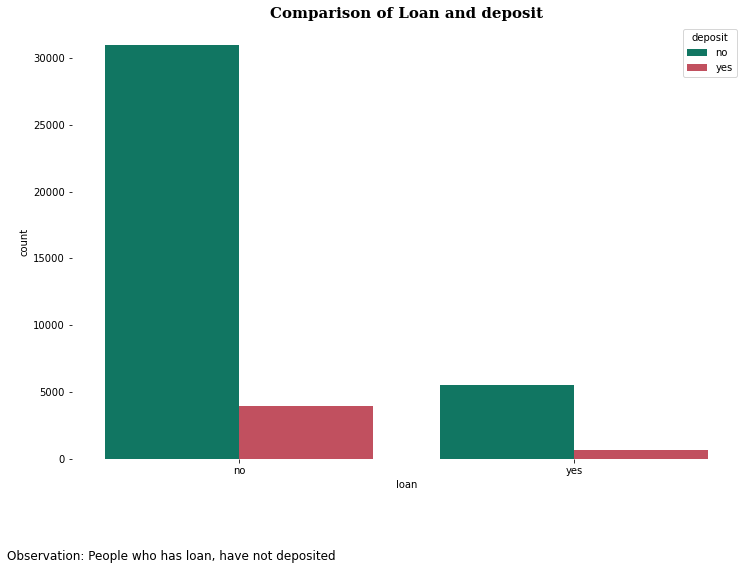

In [24]:
fig = plt.figure(figsize=(12,8))
ax=sns.countplot(data=bank_df, x='loan', hue='deposit', palette=['#00876c','#d43d51'])
ax.set_title('Comparison of Loan and deposit', font='Serif', weight='bold', size=15)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


Analisis
- Orang yang memiliki loan (utang), jarang/sedikit yang memiliki deposit

Text(0.05, -0.05, 'Observation:\n Loan has bigger impact on the deposits, people who has loans has less deposits.\n people deposited with loan is between the age of 30 to 50. people deposited without loan is from 30 to 60 year. so people getting olde preferes deposits than the loan')

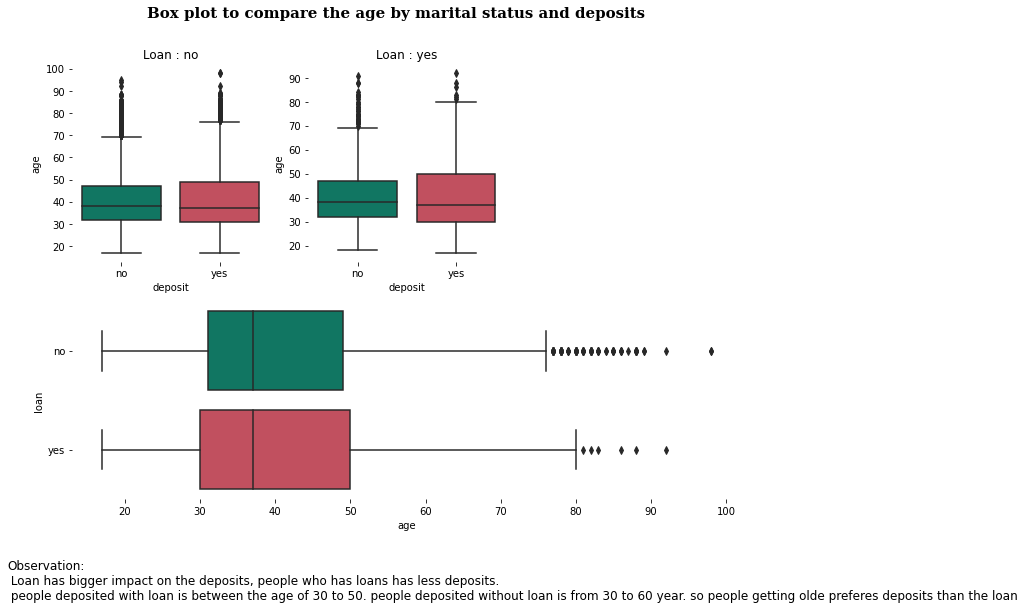

In [25]:
fig = plt.figure(figsize=(12,8))
gs = GridSpec(ncols=3, nrows=2, figure=fig)
plt.suptitle("Box plot to compare the age by marital status and deposits", family='Serif', weight='bold', size=15)
for i,c in enumerate(bank_df['loan'].unique()):
    ax=plt.subplot(gs[0,i])
    ax=sns.boxplot(y=bank_df[bank_df['loan']==c]['age'], x=bank_df['deposit'],palette=['#00876c','#d43d51']);
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title("Loan : {}".format(c))

ax=plt.subplot(gs[1,:])
ax=sns.boxplot(data=bank_df[bank_df['deposit']=='yes'],y='loan',x='age', palette=['#00876c','#d43d51','#f7e382'])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


Analisis
- Loan (hutang) menjadi faktor utama untuk deposit, orang yang punya loan hanya memiliki sedikit deposits
- Orang yang memiliki hutang umurnya dari 30 hingga 50 tahun. Orang yang berlangganan deposit tanpa loan dari umur 30 - 60 tahun. Jadi orang yang lebih tua akan lebih menyukai deposit dibandingkan loan.

In [26]:
bank_df.groupby(['loan']).describe()['age']

,count,mean,std,min,25%,50%,75%,max
loan,,,,,,,,
no,34919.0,40.038833,10.404117,17.0,32.0,38.0,47.0,98.0
yes,6242.0,39.806152,10.283199,17.0,32.0,38.0,47.0,92.0


<AxesSubplot:xlabel='campaign', ylabel='count'>

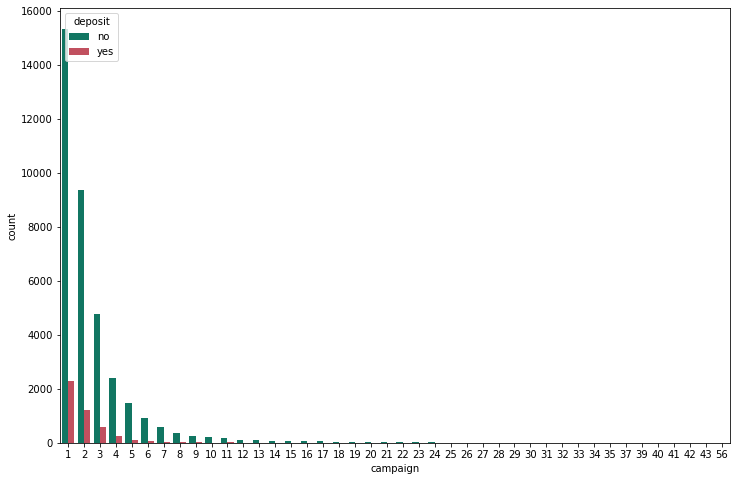

In [27]:
# mari kita periksa apakah kampanye memiliki perubahan deposit yang signifikan
fig=plt.figure(figsize=(12,8))
sns.countplot(data=bank_df,x='campaign',hue='deposit', palette=['#00876c','#d43d51'])

Analisis
- Jumlah dihubungi selama campagin semakin besar, terlihat adanya tidak.

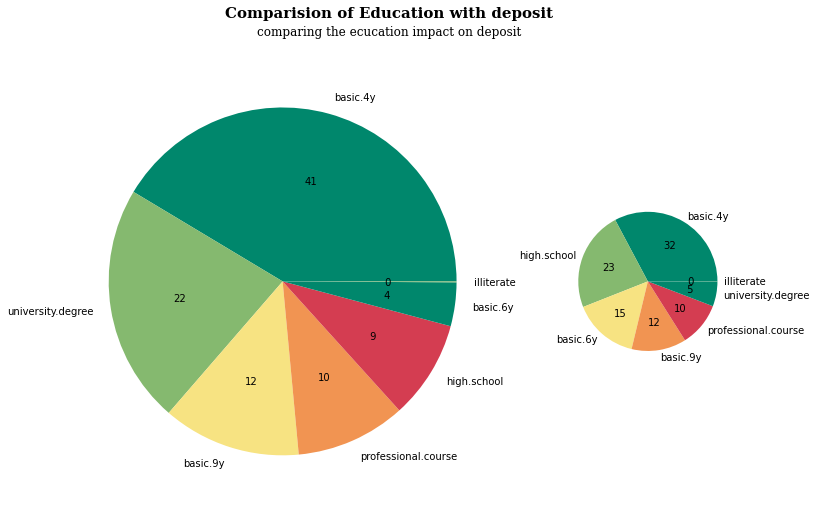

In [28]:
fig = plt.figure(figsize=(12,8))
plt.suptitle("Comparision of Education with deposit", family='Serif', size=15, ha='center', weight='bold')
plt.figtext(0.5,0.93,"comparing the ecucation impact on deposit", family='Serif', size=12, ha='center')
gs = GridSpec(nrows=1, ncols=2, width_ratios=[5,2])
ax1=plt.subplot(gs[0,0])
ax1=plt.pie(bank_df[bank_df['deposit']=='yes']['education'].value_counts(), labels=bank_df[bank_df['deposit']=='yes']['education'].unique(), autopct='%2d', colors=cols)
ax2=plt.subplot(gs[0,1])
ax2=plt.pie(bank_df[bank_df['deposit']=='no']['education'].value_counts(), labels=bank_df[bank_df['deposit']=='no']['education'].unique(), autopct='%2d', colors=cols)

Analisis
- Perbandingan berdasarkan pendidikan hampir seimbang. Bisa dilihat pada diagram, berapa % yang memiliki dibanding tidak.

### Data Manipulation
 Langkah selanjutnya adalah menentukan variabel mana saja yang berpengaruh secara signifikan dengan heatmap dan hasil analisis sebelumnya. Sebelum itu, lakukan dulu encoding untuk mengubah categorical value ke numerical value.

#### Manipulasi Kolom pdays
Kolom pdays mengindikasikan seberapa lama customer dikontak dari hari ini.
- Jika pdays = 999, mengindikasikan tidak pernah dikontak sebelumnya
- Jika pdays = 1, mengindikasikan baru-baru ini dikontak

Lebih bagus untuk mengubah dari 999 ke 0 dan pernah dikontak menjadi 1 agar lebih simpel.

In [29]:
def pdayswork(pdays):
    if(pdays == 999):
        return(0)
    elif(pdays >= 0):
        return(1)
bank_df['pdays2'] = bank_df['pdays'].apply(pdayswork)

<AxesSubplot:>

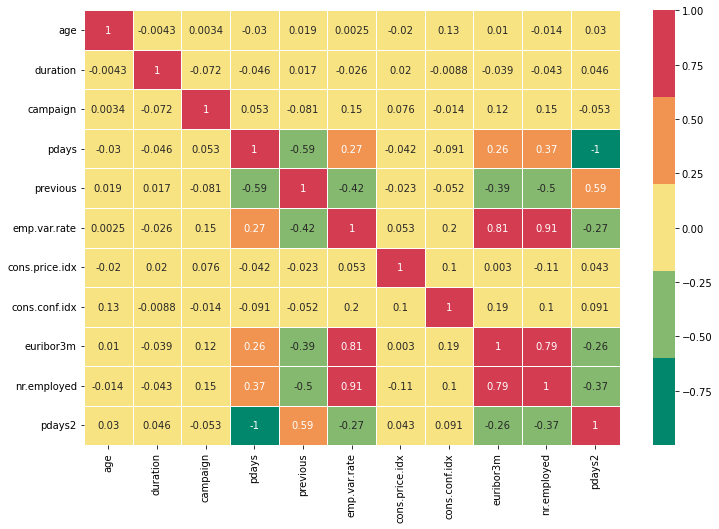

In [30]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(bank_df.corr(), cmap=cols, annot=True, linewidths=0.5)

#### Encoding Kategorical Value
Atribut kategorikal dapat dipisah menjadi tipe ordinal (ada tingkatan) dan nominal (setara)

- Nominal Atribut : job, education, contact, month, day of week, poutcome.
- Ordinal Atribut : marital, default, housing, loan, y (deposit

In [31]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41161 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41161 non-null  int64  
 1   job             41161 non-null  object 
 2   marital         41161 non-null  object 
 3   education       41161 non-null  object 
 4   default         41161 non-null  object 
 5   housing         41161 non-null  object 
 6   loan            41161 non-null  object 
 7   contact         41161 non-null  object 
 8   month           41161 non-null  object 
 9   day_of_week     41161 non-null  object 
 10  duration        41161 non-null  int64  
 11  campaign        41161 non-null  int64  
 12  pdays           41161 non-null  int64  
 13  previous        41161 non-null  int64  
 14  poutcome        41161 non-null  object 
 15  emp.var.rate    41161 non-null  float64
 16  cons.price.idx  41161 non-null  float64
 17  cons.conf.idx   41161 non-null 

In [32]:
# mengelompokkan kolomnya
numerical_columns = list(bank_df.select_dtypes(include=['int64']).columns.values) + list(bank_df.select_dtypes(include=['float64']).columns.values)
categorical_columns = list(bank_df.select_dtypes(include=['object']))

In [33]:
# memilih atribut nominal dari tipe kolom kategorical
nominal_columns = ['job', 'education', 'contact', 'month', 'day_of_week', 'poutcome']
ordinal_columns = [col for col in categorical_columns if col not in nominal_columns]

In [34]:
# One hot encoding untuk nominal atribut
ohe_bank_df = pd.get_dummies(bank_df[nominal_columns], columns=nominal_columns, prefix=nominal_columns)

# label encoding untuk ordinal atribut
le_bank_df = bank_df.loc[:, ordinal_columns]
encoder = LabelEncoder()

for ord_col in ordinal_columns:
  le_bank_df[ord_col] = encoder.fit_transform(le_bank_df[ord_col])

# gabungkaan keduanya
bank_df_categorical_encoded = pd.concat([ohe_bank_df,le_bank_df], axis=1)

In [35]:
# Hasil encodingnya
bank_df_categorical_encoded.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,marital,default,housing,loan,deposit
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,1,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0


#### Pengaruh tipe kategorikal pada dependent variabel (kolom deposit)
tipe kategorical dapat diukur dengan Chi-Squared

In [36]:
# mendapatkan daftar kolom baru hasil encoding
e_categorical_columns = list(bank_df_categorical_encoded)
e_categorical_columns.remove('deposit')

# menyiapkan kolom independent variabel dan dependent variabel
X_categorical = bank_df_categorical_encoded.drop('deposit', axis=1)
y_categorical = bank_df_categorical_encoded['deposit']

In [37]:
chi_square_fs = SelectKBest(score_func=chi2, k='all')

# fit chi-square into data
X_categorical_selected = chi_square_fs.fit_transform(X_categorical,y_categorical)

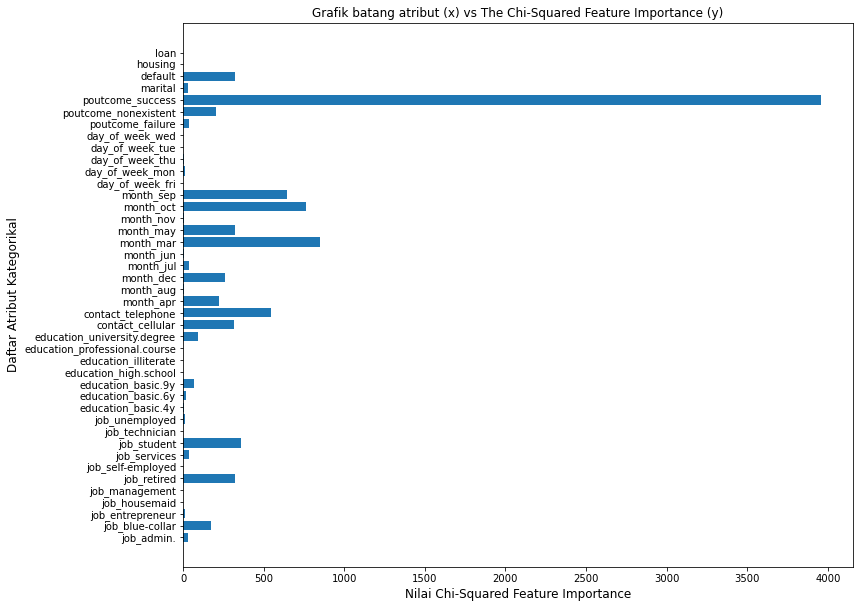

In [38]:
# Plotting score setiap kolom kategorikal
plt.figure(figsize=(12,10))
plt.barh([cat_col for cat_col in e_categorical_columns], chi_square_fs.scores_)
plt.ylabel('Daftar Kolom Kategorikal', fontsize=12)
plt.xlabel('Nilai Chi-Squared Feature Importance', fontsize=12)
plt.title('Grafik batang  (x) vs The Chi-Squared Feature Importance (y)',fontsize=12)
plt.show()

Atribut **poutcome_success** menjadi atribut kategorikal yang memberikan kepentingan atribut tertinggi dibandingkan dengan yang lainnya.

#### Pengaruh kolom numerical pada dependent variabel (kolom deposit)
tipe kategorical dapat diukur dengan ANOVA F-score

In [1]:
# menyiapkan independent variabel dan dependent variabel
X_numerical = bank_df[numerical_columns].copy(deep=True)
y_numerical = y_categorical.copy(deep=True)

NameError: name 'bank_df' is not defined

In [40]:
anova_fs = SelectKBest(score_func=f_classif,k='all')

# fit into data
X_numerical_selected = anova_fs.fit_transform(X_numerical,y_numerical)

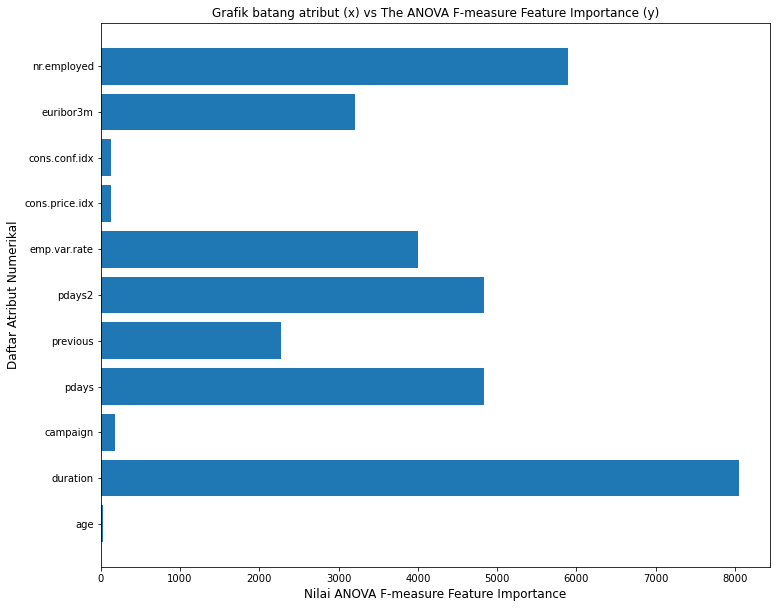

In [41]:
# Plotting score setiap tipe kelas kategorikal
plt.figure(figsize=(12,10))
plt.barh([num_col for num_col in list(X_numerical.columns)], anova_fs.scores_)
plt.ylabel('Daftar Atribut Numerikal', fontsize=12)
plt.xlabel('Nilai ANOVA F-measure Feature Importance', fontsize=12)
plt.title('Grafik batang atribut (x) vs The ANOVA F-measure Feature Importance (y)',fontsize=12)
plt.show()

Kolom duration memiliki kepentingan yang paling tinggi dibandingkan kolom numerikal lainnya. Dapat disimpulkan berlangganan deposito memiliki korelasi dengan durasi pemasaran/kampanye yang dilakukan pihak bank melalui telepon

In [42]:
# menyatukan kembali data
bank_df_ready = pd.concat([bank_df[numerical_columns],bank_df_categorical_encoded],axis=1)

#### Pembagian Dataset ke Data Latih & Data Uji
- Pembagian 80% data latih dan 20% data uji.
- Data latih akan digunakan untuk tuning parameter dan hyperparmaeter serta melakukan feature selection.
- Data uji untuk menguji performa model klasifikasi yang sudah dulatih sebelumnya.

In [43]:
# pembagian data
X = bank_df_ready.drop('deposit', axis=1)
y = bank_df_ready['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
# dimensi data setelah dibagi
print('Dimensi data latih ', X_train.shape)
print('Dimensi data uji', X_test.shape)
print('Dimensi target data latih', y_train.shape)
print('Dimensi target data uji', y_test.shape)


Dimensi data latih=  (32928, 53)
Dimensi data uji (8233, 53)
Dimensi target data latih (32928,)
Dimensi target data uji (8233,)


#### Normalisasi Data
Metode Normalisasi z-score digunakan untuk menyamakan skala dari setiap atribut pada data ke standard normal distribution (mean = 0, std=1)

In [46]:
# melakukan sclaer dengan kelas standard_scaler
standard_scaler = StandardScaler()
standard_scaler.fit(X_train)

# transformasi data
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

#### Dimensionality Reduction
Jumlah dimensi akan dikurangi dengan PCA

In [47]:
# mereduksi dimensi dengan kelas PCA
pca_ = PCA()
pca_.fit(X_train)

# mencetak nilai eigen setiap principal component
print('Nilai Eigen setiap Principal Component')
print(pca_.explained_variance_)
print("="*30)

# mencetak ratio masing-masing nilai eigen terhadap keseluruhan
print('Rasio Nilai Eigen setiap Principal Component')
print(pca_.explained_variance_ratio_)
print("="*30)

Nilai Eigen setiap Principal Component
[5.61884707e+00 2.87595072e+00 2.60985835e+00 2.16997297e+00
 2.00832668e+00 1.93195625e+00 1.78221519e+00 1.66188917e+00
 1.54625526e+00 1.49403625e+00 1.27164144e+00 1.26066489e+00
 1.24906448e+00 1.23681498e+00 1.22280608e+00 1.15560325e+00
 1.14146406e+00 1.11413290e+00 1.07889257e+00 1.05450170e+00
 1.04380906e+00 1.03724885e+00 1.03077782e+00 1.02033961e+00
 1.01075236e+00 9.99776493e-01 9.89173238e-01 9.86722612e-01
 9.60005730e-01 9.48217001e-01 8.89275261e-01 8.64619426e-01
 8.33982921e-01 7.95250263e-01 7.33547240e-01 7.13035750e-01
 6.10626503e-01 4.42977871e-01 4.38487210e-01 4.24308794e-01
 2.44013001e-01 1.82684479e-01 1.41824486e-01 6.79493569e-02
 6.54298525e-02 4.18735192e-02 6.63874550e-06 1.10812220e-30
 4.00171325e-31 1.66416206e-31 8.66991562e-32 3.37681262e-32
 3.34160743e-32]
Rasio Nilai Eigen setiap Principal Component
[1.06012763e-01 5.42615732e-02 4.92411149e-02 4.09416428e-02
 3.78918055e-02 3.64508978e-02 3.36256804e-02

In [48]:
# membuat dataframe untuk memplotting variance ratio yang dihasilkan PCA
pca_variance = pd.DataFrame(data=pca_.explained_variance_ratio_,columns=['PC Variance'])
pca_variance['pc_name'] = pd.Series(data=['PC-'+str(i+1) for i in range(0,X_train.shape[1])])
pca_variance = pca_variance.sort_values(by='PC Variance')

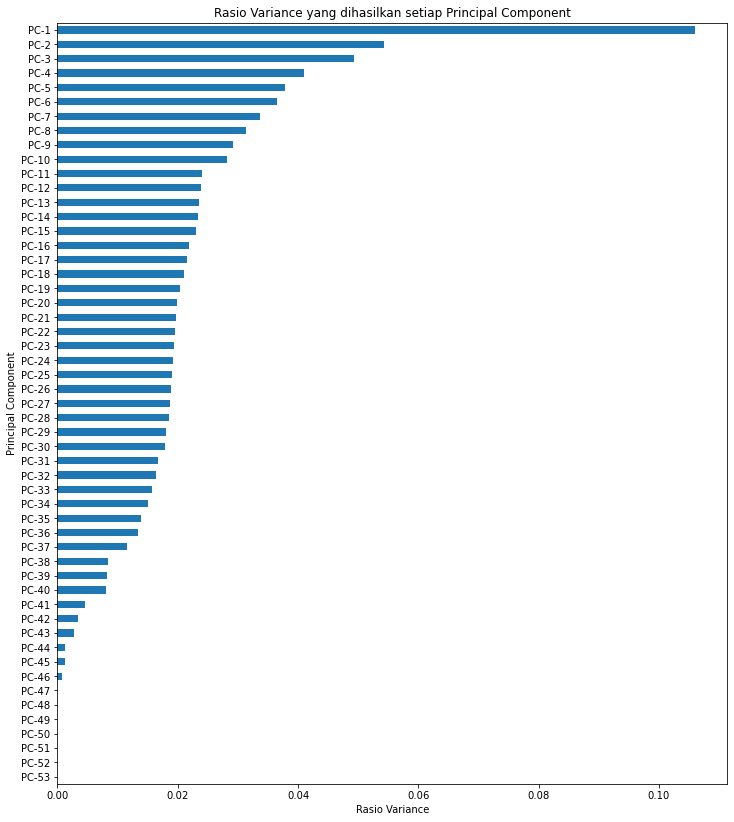

In [49]:
# Plotting variance ratio yang dijelaskan setiap component
plt.figure(figsize=(12,14))
pca_variance['PC Variance'].plot(kind='barh')
plt.yticks(ticks=range(0,X_train.shape[1]), labels=pca_variance['pc_name'])
plt.title('Rasio Variance yang dihasilkan setiap Principal Component')
plt.xlabel('Rasio Variance')
plt.ylabel('Principal Component')
plt.show()

Mencari jumlah principal component terbaik.

Ada beberapa metode untuk menentukan jumlah principal component terbaik yang harus digunakan. Salah satu sumber menyebutkan: <br>
1. Jumlah PC terbaik yang terpilih adalah PC yang menghasilkan nilai eigen lebih besar atau sama dengan 1


In [50]:
# Mencari komponen yang menghasilkan nilai eigen value >= 1
def find_best_n_components(pca): 
    n_best_component = 0
    for i in range(0,len(pca.explained_variance_)):
        if pca.explained_variance_[i]>=1:
            n_best_component+=1
    
    return n_best_component

In [51]:
# mencari jumlah principal component terbaik
n_components = find_best_n_components(pca_)
print('Jumlah n Principal Component terbaik = {} komponen'.format(n_components))
print('Informasi yang dijelaskan oleh {} komponen = {} %'.format(n_components,(np.sum(pca_.explained_variance_ratio_[:n_components]))*100))
print('Kehilangan Informasi = {} %'.format(100-(np.sum(pca_.explained_variance_ratio_[:n_components]))*100))

Jumlah n Principal Component terbaik = 25 komponen
Informasi yang dijelaskan oleh 25 komponen = 76.65393988131348 %
Kehilangan Informasi = 23.346060118686523 %


Instansiasi PCA dengan n component terbaik
1. Buat PCA dengan n component terbaik
2. Fitting ke data latih 
3. Transform ke atribut data latih dan data uji

In [52]:
pca_ = PCA(n_components=n_components)
pca_.fit(X_train)

# transform into train and test data
X_train_pca = pca_.transform(X_train)
X_test_pca = pca_.transform(X_test)

In [ ]:
# buat dataframe untuk mempermudah melihat data hasil PCA
train_pca_df = pd.DataFrame(data=X_train_pca,columns=['PC-'+str(i) for i in range(0,n_components)])
train_pca_df['target'] = y_train.to_numpy()

test_pca_df = pd.DataFrame(data=X_test_pca,columns=['PC-'+str(i) for i in range(0,n_components)])
test_pca_df['target'] = y_test.to_numpy()

In [ ]:
# informasih hasil PCA
train_pca_df.head()

,PC-0,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,...,PC-16,PC-17,PC-18,PC-19,PC-20,PC-21,PC-22,PC-23,PC-24,target
0,-2.267525,2.004332,-0.984522,0.835119,0.678190,-0.818218,0.027733,-0.929256,0.248643,0.423537,...,-1.001808,3.810484,-1.091281,0.134824,0.283155,1.345225,0.537710,1.016461,0.043448,0
1,-1.428960,1.199297,0.437944,-2.022498,1.149570,1.528953,-0.907447,-0.630370,0.713399,-0.074059,...,-1.056721,-1.352318,-0.787665,0.221671,-0.204489,0.795890,-0.537523,-0.124221,-0.488198,0
2,-2.378351,1.966926,-0.331879,1.087885,0.472025,0.445303,-0.688875,-0.320953,-0.792022,2.499792,...,0.756261,-0.882115,2.292902,-0.935946,2.737590,1.758380,-0.002475,2.150931,-1.021133,0
3,-2.485488,2.213012,-0.964848,0.814535,0.745057,-0.962606,-0.151289,-1.012110,0.248452,0.779240,...,-0.734269,3.372655,-1.763105,-0.449679,1.106370,0.466346,0.783372,0.555691,0.731386,0
4,8.961431,4.437443,3.425035,-1.096102,0.444711,-2.888103,-0.842640,0.531613,-0.827614,-0.826710,...,-1.630255,-0.566139,0.187960,-4.539572,2.657515,-1.707247,0.176679,-2.091735,0.401290,1


In [ ]:
y_train.head()

8191     0
3725     0
9736     0
10008    0
39159    1
Name: deposit, dtype: int32

In [ ]:
test_pca_df.head()

,PC-0,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,...,PC-16,PC-17,PC-18,PC-19,PC-20,PC-21,PC-22,PC-23,PC-24,target
0,-1.520051,0.691437,-0.887092,-0.577084,-0.236107,-1.794960,-0.545906,3.053560,-0.937731,0.802593,...,0.971291,-0.227638,-0.625818,0.040796,0.217055,0.451012,0.218431,0.174438,-0.210092,0
1,-1.326377,-0.584973,-0.266017,1.754497,-1.294005,-2.444012,-0.464130,-1.084978,0.865945,-0.675966,...,1.215427,-0.144737,0.367149,0.399107,-0.660083,0.013970,-0.271011,-0.054443,-0.119135,0
2,-1.805976,1.643707,-0.448166,-0.864204,0.675141,0.686691,-0.671690,1.791088,0.234468,-0.180969,...,-1.242779,-0.538921,-0.161547,0.263230,-0.032023,0.058710,0.126046,0.291251,0.032498,0
3,-1.557157,1.079699,0.582320,-1.932156,0.750310,0.863883,1.490492,-1.237146,0.441404,-0.687554,...,-0.606033,-0.749071,-0.051821,-0.278103,-0.289611,0.650819,-0.380401,-0.518637,-0.562944,0
4,1.386100,0.714277,-0.800433,2.757392,-1.788513,3.033014,-1.479821,1.552077,-1.980949,0.252390,...,0.023477,0.208624,0.045144,-0.751259,-0.025615,1.099963,-0.667911,-1.032315,-0.798369,1


In [ ]:
y_test.head()

12469    0
16106    0
144      0
6442     0
40005    1
Name: deposit, dtype: int32

### Pembuatan Model
Model klasifikasi *machine learning* yang digunakan pada tugas ini yaitu: <br>
1. Logistic Regression
2. KNN
3. SVM
4. Decision Tree
5. Random Forest
6. Naive Bayes


In [ ]:
# Inisialisasi fold dan scoring yang digunakan
num_fold = 10
scoring_accuracy ='accuracy'
scoring_recall = 'recall'

In [ ]:
# buat list dari seluruh model yang digunakan
models = []

# append model
models.append(('Logistic Regression', LogisticRegression()))
models.append(('K-Nearest Neighbor', KNeighborsClassifier()))
models.append(('Support Vector Machine', SVC()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Naive Bayes', GaussianNB()))

#k-fold cross validation initialization object
kfold = KFold(n_splits=num_fold, random_state=42, shuffle=True)

In [ ]:
#Fungsi ini digunakan untuk melakukan model cross-validation dengan data latih yang ada. Setiap model akan divalidasi dengan ukuran skor (scoring) yang telah ditetapkan, semisal (akurasi, recall, etc).
        
def perform_model(models,X_train,y_train,kfold, scoring='accuracy'):
    cv_results = [] #menampung hasil crossvalidation setiap model
    model_names = [] #menampung nama model
    print_msg = [] #menampung pesan yang akan ditampilkan
    
    
    for model_name, model in models:
        # cross validation result
        cv_result = cross_val_score(model,X_train,y_train, cv=kfold,scoring=scoring)

        # tambah ke list
        cv_results.append(cv_result)
        model_names.append(model_name)

        # tampilkan
        msg_result = "{}: mean {} = {}  std {} = {}".format(model_name,scoring,cv_result.mean(),scoring,cv_result.std())
        print_msg.append(msg_result)
    
    return cv_results,model_names,print_msg

In [ ]:
# Hitung mean dari validasi yang digunakan
cv_results_accuracy, model_names, print_msg_accuracy = perform_model(
    models=models,
    X_train=X_train_pca,
    y_train=y_train,
    kfold=kfold,
    scoring=scoring_accuracy
)

In [ ]:
# cetak hasil rata-rata akurasi setiap model
for msg in print_msg_accuracy:
    print(msg)

Logistic Regression: mean accuracy = 0.9008743093988907  std accuracy = 0.005869512427443833
K-Nearest Neighbor: mean accuracy = 0.8944664923090659  std accuracy = 0.006602945445362256
Support Vector Machine: mean accuracy = 0.9045795437060609  std accuracy = 0.007354168822743062
Decision Tree: mean accuracy = 0.8737848870482289  std accuracy = 0.007837042209428458
Random Forest: mean accuracy = 0.902878874478394  std accuracy = 0.006911968233019625
Naive Bayes: mean accuracy = 0.8702623463224579  std accuracy = 0.007557193250674


#### Hasil Akurasi Tiap Model

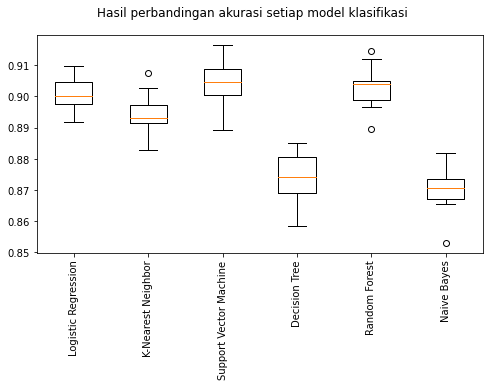

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Hasil perbandingan akurasi setiap model klasifikasi')
ax = fig.add_subplot(111)

plt.boxplot(cv_results_accuracy)
ax.set_xticklabels(model_names, rotation=90)
fig.set_size_inches(8,4)
plt.show()

Analisis
1. Dari segi akurasi Logistic Regression, SVM, dan Random Forest tampil menjadi model terbaik dengan rata-rata akurasi ketiga model ini yang hampir sama. 
2. Decision Tree dan Naive Bayes memberikan performa akurasi paling rendah

#### Analisis Recall
Ukuran performa yang digunakan pada permasalahan ini adalah memaksimalkan recall. SVM dibandingkan karena akurasi sebelumnya tinggi.

In [ ]:
# inisialisasi model SVM dengan default parameter
svm = SVC()

# fit model into training data
svm.fit(X_train_pca,y_train)

# get y prediction
y_pred = svm.predict(X_test_pca)

In [ ]:
# print results
print("SVM Recall score = ", metrics.recall_score(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred))

# confusion matrix
print(metrics.confusion_matrix(y_test,y_pred))

SVM Recall score =  0.34063526834611174
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7320
           1       0.65      0.34      0.45       913

    accuracy                           0.91      8233
   macro avg       0.78      0.66      0.70      8233
weighted avg       0.89      0.91      0.89      8233

[[7149  171]
 [ 602  311]]


Analisis <br>
Model SVM walaupun memberikan nilai rata-rata akurasi tertinggi, namun nyatanya masih belum maksimal dalam memberikan recall terbaik. Hal ini dibuktikan dengan nilai FN yang besar


#####
 Tuning Model
Recall akan digunakan untuk mentuning model yang digunakan

In [ ]:
cv_results_recall, model_names, print_msg_recall = perform_model(
    models=models,
    X_train=X_train_pca,
    y_train=y_train,
    kfold=kfold,
    scoring=scoring_recall
)

In [ ]:
# cetak hasil rata-rata recall setiap model
for msg in print_msg_recall:
    print(msg)

Logistic Regression: mean recall = 0.29664650730467795  std recall = 0.019529563900754904
K-Nearest Neighbor: mean recall = 0.29547631051208906  std recall = 0.02618358311455535
Support Vector Machine: mean recall = 0.32378440553788335  std recall = 0.024037298302824438
Decision Tree: mean recall = 0.44830739487278004  std recall = 0.029668945286385764
Random Forest: mean recall = 0.390494395222211  std recall = 0.030057463077494986
Naive Bayes: mean recall = 0.41887625951134383  std recall = 0.02471761383185259


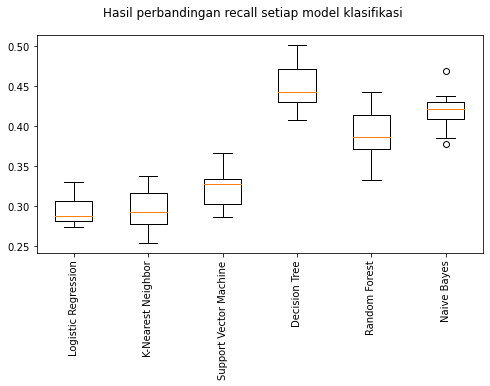

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Hasil perbandingan recall setiap model klasifikasi')
ax = fig.add_subplot(111)

plt.boxplot(cv_results_recall)
ax.set_xticklabels(model_names, rotation=90)
fig.set_size_inches(8,4)
plt.show()

Analisis
1. Decision Tree dan Naive Bayes tampil dengan rata-rata recall terbaik dibandingkan model-model lainnya.
2. Akurasi pada dataset yang imbalanced tidak bisa menjadi penentu untuk memilih model. Bisa dilihat bahwa SVM tidak mampu memberikan performa recall yang terbaik, padahal sebelumnya model ini memberikan akurasi tertinggi.

In [ ]:
# inisialisasi model Decision Tree
dt = DecisionTreeClassifier()

# fit model into training data
dt.fit(X_train_pca,y_train)

# get y prediction
y_pred_dt = dt.predict(X_test_pca)

In [ ]:
# print score
print("Accuracy score Decision Tree = ", metrics.accuracy_score(y_test,y_pred_dt))
print(metrics.classification_report(y_test,y_pred_dt))

# confusion matrix
print(metrics.confusion_matrix(y_test,y_pred_dt))

Accuracy score Decision Tree =  0.8756224948378477
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7320
           1       0.44      0.46      0.45       913

    accuracy                           0.88      8233
   macro avg       0.69      0.70      0.69      8233
weighted avg       0.88      0.88      0.88      8233

[[6785  535]
 [ 489  424]]


Decision Tree masih memberikan FN dan FP yang terbilang masih tinggi.

### Evaluasi model

#### Tuning Model dengan Undersampling

Ketidakseimbangan terjadi pada variabel dependent. Model yang ingin dikembangkan adalah sebisa mungkin meminimumkan adanya FN, sehingga perlu dilakukan penyeimbangan pada label kelas. Salah satu caranya dengan undersampling

In [ ]:
# menyatukan atribut dan target pada data latih
df_balance = pd.concat([pd.DataFrame(data=X_train_pca),y_train.reset_index()['deposit']],axis=1)

In [ ]:
df_balance

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,deposit
0,-2.267525,2.004332,-0.984522,0.835119,0.678190,-0.818218,0.027733,-0.929256,0.248643,0.423537,...,-1.001808,3.810484,-1.091281,0.134824,0.283155,1.345225,0.537710,1.016461,0.043448,0
1,-1.428960,1.199297,0.437944,-2.022498,1.149570,1.528953,-0.907447,-0.630370,0.713399,-0.074059,...,-1.056721,-1.352318,-0.787665,0.221671,-0.204489,0.795890,-0.537523,-0.124221,-0.488198,0
2,-2.378351,1.966926,-0.331879,1.087885,0.472025,0.445303,-0.688875,-0.320953,-0.792022,2.499792,...,0.756261,-0.882115,2.292902,-0.935946,2.737590,1.758380,-0.002475,2.150931,-1.021133,0
3,-2.485488,2.213012,-0.964848,0.814535,0.745057,-0.962606,-0.151289,-1.012110,0.248452,0.779240,...,-0.734269,3.372655,-1.763105,-0.449679,1.106370,0.466346,0.783372,0.555691,0.731386,0
4,8.961431,4.437443,3.425035,-1.096102,0.444711,-2.888103,-0.842640,0.531613,-0.827614,-0.826710,...,-1.630255,-0.566139,0.187960,-4.539572,2.657515,-1.707247,0.176679,-2.091735,0.401290,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32923,-1.663485,2.364010,0.180310,1.958416,-0.626095,2.722058,1.378499,1.584065,-0.373068,-0.132620,...,0.244078,-0.314967,-0.519509,0.383339,0.842671,0.312397,-0.615004,-0.504880,0.769483,0
32924,-1.880566,0.969016,0.707028,-0.950901,1.721098,0.860041,-1.011120,-1.280653,-0.868254,2.313780,...,1.549208,1.767102,0.020889,-0.284222,-0.558388,-1.191852,-1.231194,-0.692036,0.159879,0
32925,2.577562,-0.581309,0.816781,-1.921172,-1.105550,3.092975,-1.265637,-0.621720,-1.330642,-2.442471,...,0.546588,-0.061959,-2.403791,2.459003,1.256849,-0.515458,-0.648150,0.379318,-3.283328,0
32926,-1.477790,1.113892,0.376104,-1.022952,1.464175,1.780810,-0.683312,-1.118472,0.376573,-0.409430,...,1.092960,0.609297,0.287921,-0.657104,-0.859550,-0.224095,-0.615523,-0.589154,-0.247059,0


In [ ]:
# melihat banyak setiap nilai pada label kelas
df_balance['deposit'].value_counts()

0    29215
1     3713
Name: deposit, dtype: int64

In [ ]:
# under-sampling kelas deposit
no_df = df_balance[df_balance['deposit']==0][:df_balance['deposit'].value_counts()[1]]
yes_df = df_balance[df_balance['deposit']==1]

In [ ]:
# menggabungkan dataset yang setiap kelasnya sudah balanced menjadi 1
normal_distributed_df = pd.concat([yes_df,no_df])

# shuffle row pada data yang sudah digabung agar acak
bank_df_normal_distributed = normal_distributed_df.sample(frac=1, random_state=42)

In [ ]:
bank_df_normal_distributed.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,deposit
10003,-0.956334,-1.066456,2.598179,-1.286009,-0.370722,0.614898,-1.002779,-0.496702,1.529965,-0.356464,...,-0.152403,0.369552,0.292230,0.847571,0.408568,-0.770313,-0.685493,0.172168,0.476583,1
24663,2.853162,-0.109000,-0.921331,-2.280518,-1.700762,0.313132,-0.107961,-2.011735,-2.291132,-3.686019,...,3.824340,-2.450536,-1.616688,1.476287,-4.324873,4.575623,-3.644296,-2.876954,9.476027,1
757,1.718905,0.986280,0.077825,-2.400312,0.067816,2.791077,-1.338776,-0.804614,-0.857387,-1.734412,...,0.611328,0.029901,-1.789743,-0.373829,-2.215152,1.497785,2.320661,2.942935,-0.326836,1
2108,0.968209,-0.974009,-2.017810,-2.093013,-0.596734,-1.270267,0.176347,2.107426,-1.251847,-1.434573,...,0.267868,-0.021145,0.145739,-1.219721,0.121092,-0.050716,0.539338,-0.524317,-0.336017,0
3149,-1.434309,0.892389,0.453347,-2.075559,0.479858,0.922208,1.483400,-1.259538,-0.223857,0.134287,...,-0.384865,-0.810712,-0.259789,0.379476,0.097847,0.032430,-0.135611,-0.138027,-0.159785,0


In [ ]:
X_train_balanced = bank_df_normal_distributed.drop('deposit',axis=1)
y_train_balanced = bank_df_normal_distributed['deposit']

In [ ]:
print('Distribusi setiap kelas dari subsampel dataset')
print(bank_df_normal_distributed['deposit'].value_counts()/len(bank_df_normal_distributed))

Distribusi setiap kelas dari subsampel dataset
1    0.5
0    0.5
Name: deposit, dtype: float64


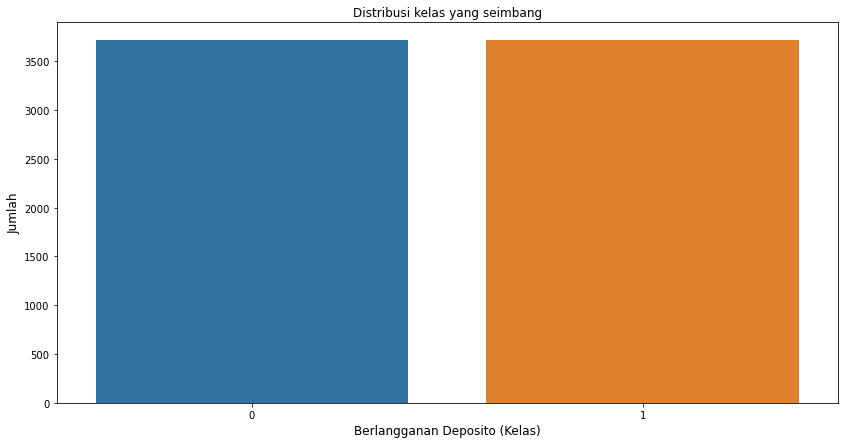

In [ ]:
plt.figure(figsize=(14,7))
sns.countplot(x='deposit', data=bank_df_normal_distributed)
plt.title('Distribusi kelas yang seimbang', fontsize=12)
plt.xlabel('Berlangganan Deposito (Kelas)', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.show()

Analisis </br>
Data latih kita sudah memiliki proporsi kelas yang seimbang. Kini akan dilakukan training ulang pada model dan melihat evaluasinya dengan scoring accuracy karena subsample sudah disampling dengan seimbang

#### Training model dengan kelas data latih yang sudah seimbang

In [ ]:
cv_results_accuracy, model_names, print_msg_accuracy = perform_model(
    models=models,
    X_train=X_train_balanced,
    y_train=y_train_balanced,
    kfold=kfold,
    scoring=scoring_accuracy
)

In [ ]:
# cetak hasil rata-rata akurasi setiap model
for msg in print_msg_accuracy:
    print(msg)

Logistic Regression: mean accuracy = 0.8241332399792494  std accuracy = 0.015350657266185282
K-Nearest Neighbor: mean accuracy = 0.7767341548976431  std accuracy = 0.02019313826498894
Support Vector Machine: mean accuracy = 0.8653395754807673  std accuracy = 0.012098183129340568
Decision Tree: mean accuracy = 0.790061780571951  std accuracy = 0.014710719702437081
Random Forest: mean accuracy = 0.8606274918103557  std accuracy = 0.012603439645845756
Naive Bayes: mean accuracy = 0.6925656531944148  std accuracy = 0.02016780198506147


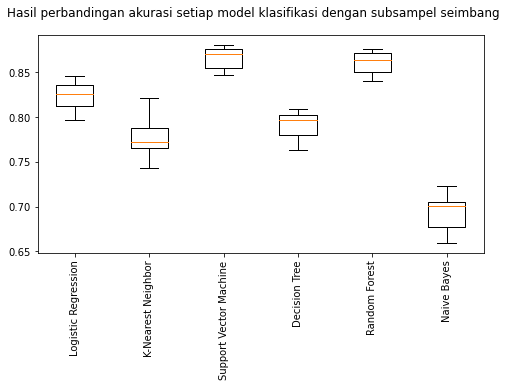

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Hasil perbandingan akurasi setiap model klasifikasi dengan subsampel seimbang')
ax = fig.add_subplot(111)

plt.boxplot(cv_results_accuracy)
ax.set_xticklabels(model_names, rotation=90)
fig.set_size_inches(8,4)
plt.show()

Analisis <br>
Model SVM tampil memberikan rata-rata akurasi tertinggi ketika model dilatih dengan data latih yang seimbang sehingga kita mengetest SVM

In [ ]:
# inisialisasi model
svm_balanced = SVC()

# fit model into training data
svm_balanced.fit(X_train_balanced,y_train_balanced)

# get y prediction
y_pred_balanced = svm_balanced.predict(X_test_pca)


In [ ]:
# print score
print("Accuracy score SVM with balanced subsample = ", metrics.accuracy_score(y_test,y_pred_balanced)," %")

# confusion matrix
print(metrics.confusion_matrix(y_test,y_pred_balanced))

# hasil klasifikasi
print(metrics.classification_report(y_test,y_pred_balanced))

Accuracy score SVM with balanced subsample =  0.8393052350297583  %
[[6091 1229]
 [  94  819]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7320
           1       0.40      0.90      0.55       913

    accuracy                           0.84      8233
   macro avg       0.69      0.86      0.73      8233
weighted avg       0.92      0.84      0.86      8233



Analisis <br>
Hasil confusion matrix pada model SVM yang dilatih dengan sample yang balanced menunjukkan adanya peningkatan nilai recall kelas '1'. <br>
1. Sebelum dilakukan under-sampling nilai recall untuk kelas '1' yaitu 0.44, sedangkan setelah di-undersampling menjadi 0.90 <br>
2. Terjadi penurunan recall untuk kelas '0' setelah undersampling dari 0.93 menjadi 0.83. Penurunannya tidak sebesar pada kenaikan recall untuk kelas '1'
Jadi dipilih SVM karena memberikan accuracy yang lebih tiggi (83,9%) serta recall yang sudah naik dibanding sebelumnya.


#### Tuning Hyperparameter dari Model Terbaik

In [ ]:
# inisialisasi SVM model
svm_params_tuned = SVC()

# inisialisasi objek KFold dengan k=10
kfold = kfold

# inisialisasi daftar hyperparameter yang akan dituning
params_grid={
    'kernel' : ['linear', 'poly', 'rbf'],
    'gamma':['scale','auto'],
}

# instansiasi grid seach objek
grid_svm = GridSearchCV(
    estimator= svm_params_tuned,
    param_grid=params_grid,
    scoring=scoring_accuracy,
    cv = kfold
)

# fit grid objek ke data train
grid_results_ = grid_svm.fit(X_train_balanced,y_train_balanced)

In [ ]:
# Cetak hyperparameter yang memberikan hasil terbaik
print('Best SVM Hyperparameter: {}'.format(grid_results_.best_params_))
print('Best SVM Accuracy Score: {}'.format(grid_results_.best_score_))

Best SVM Hyperparameter: {'gamma': 'scale', 'kernel': 'rbf'}
Best SVM Accuracy Score: 0.8653395754807673


### Finalisasi Model

In [ ]:
# instansiasi objek SVM dengan hyperparameter optimal
svm_final = SVC(gamma=grid_results_.best_params_['gamma'],kernel=grid_results_.best_params_['kernel'])


# training
svm_final.fit(X_train_balanced,y_train_balanced)

# model evaluation using data testing
y_pred_final = svm_final.predict(X_test_pca)

In [ ]:
# print score
print("Accuracy score Final Model SVM = ", metrics.accuracy_score(y_test,y_pred_final)," %")

# confusion matrix
print(metrics.confusion_matrix(y_test,y_pred_final))

# hasil klasifikasi
print(metrics.classification_report(y_test,y_pred_final))

Accuracy score Final Model SVM =  0.8393052350297583  %
[[6091 1229]
 [  94  819]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7320
           1       0.40      0.90      0.55       913

    accuracy                           0.84      8233
   macro avg       0.69      0.86      0.73      8233
weighted avg       0.92      0.84      0.86      8233

